In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd

### Load all the data for each subject

each mat.file represent 1 subject doing 1 activity

In [5]:
path = "../USC-HAD/"
activity = []
activity_num = []
sensor_reading = []
subject_num = []
for root, directories, files in os.walk(path,topdown=True): ### directories = "Subject2" e.g
    for name in files:
        if ".mat" in name:
            mat = loadmat(os.path.join(root,name))
            activity.append(mat["activity"][0])
            sensor_reading.append(mat["sensor_readings"])
            subject_num.extend(mat["subject"])
            if mat.get("activity_number") is None: ### missing activity number
                activity_num.append("99")
            else:
                activity_num.append(mat["activity_number"][0])
            

In [11]:
acc_x = []
acc_y = []
acc_z = []
gyro_x = []
gyro_y = []
gyro_z = []
subjects = []
labels = []
for i in range(len(sensor_reading)): ### for each reading in total reading
    for readings in sensor_reading[i]:
        acc_x.append(readings[0])
        acc_y.append(readings[1])
        acc_z.append(readings[2])
        gyro_x.append(readings[3])
        gyro_y.append(readings[4])
        gyro_z.append(readings[5])
        subjects.append(subject_num[i])
        labels.append(activity_num[i])

In [64]:
set(activity)

{'elevator-down',
 'elevator-up',
 'jump',
 'jumping',
 'run',
 'running',
 'sit',
 'sitting',
 'sleeping',
 'stand',
 'standing',
 'walk-downstairs',
 'walk-forward',
 'walk-left',
 'walk-right',
 'walk-up',
 'walk-upstairs',
 'walking-down',
 'walking-downstairs',
 'walking-forward',
 'walking-left',
 'walking-right',
 'walking-up',
 'walking-upstairs'}

### Create Dataframe

In [12]:
df = pd.DataFrame({"Subject_Id":subjects,"acc_x":acc_x,"acc_y":acc_y,"acc_z":acc_z,
                  "gyro_x":gyro_x,"gyro_y":gyro_y,"gyro_z":gyro_z,"labels":labels})

In [13]:
len(df)

2811490

In [14]:
df.head()

,Subject_Id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,labels
0,2,-0.653698,0.805976,-0.153035,0.291960,-0.027421,-0.910449,10
1,2,-0.657132,0.805976,-0.149374,0.692599,-0.428895,-0.506021,10
2,2,-0.653698,0.809595,-0.153035,0.288852,0.375579,-0.504430,10
3,2,-0.650265,0.809595,-0.149374,0.287940,0.374394,-0.101278,10
4,2,-0.646831,0.805976,-0.149374,0.287031,0.373212,-0.502525,10


In [15]:
df1 = df[(df.labels != "99")]

In [16]:
df1.head()

,Subject_Id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,labels
0,2,-0.653698,0.805976,-0.153035,0.291960,-0.027421,-0.910449,10
1,2,-0.657132,0.805976,-0.149374,0.692599,-0.428895,-0.506021,10
2,2,-0.653698,0.809595,-0.153035,0.288852,0.375579,-0.504430,10
3,2,-0.650265,0.809595,-0.149374,0.287940,0.374394,-0.101278,10
4,2,-0.646831,0.805976,-0.149374,0.287031,0.373212,-0.502525,10


In [17]:
len(df1)

2809281

In [18]:
no_labels = df[(df.labels=="99")]

In [19]:
len(no_labels)

2209

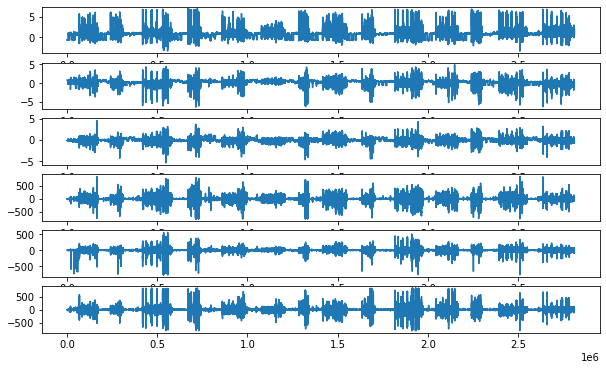

In [29]:
plt.figure(figsize=(10,6))
plt.subplot(6,1,1)
plt.plot(df1["acc_x"])
plt.subplot(6,1,2)
plt.plot(df1["acc_y"])
plt.subplot(6,1,3)
plt.plot(df1["acc_z"])
plt.subplot(6,1,4)
plt.plot(df1["gyro_x"])
plt.subplot(6,1,5)
plt.plot(df1["gyro_y"])
plt.subplot(6,1,6)
plt.plot(df1["gyro_z"])
plt.show()

### Signal Segmentation

68 number of samples in each timestep window size = 50%

In [50]:
def window(data,window_size):
    start = 0
    while start < data.count():
        yield int(start),int(start+window_size) ### generate(start,end)
        start += (window_size/2) ### 50% overlap

In [169]:
def signal_segmentation(data,window_size):
    segment = np.empty((0,window_size,6)) ### number of sample,measurements,no. samples in window_size
    labels = np.empty((0))
    subjects = np.empty((0))
    for (start,end) in window(data["labels"],window_size):
        print(start,end)
        acc_x = data["acc_x"][start:end]
        acc_y = data["acc_y"][start:end]
        acc_z = data["acc_z"][start:end]
        gyro_x = data["gyro_x"][start:end]
        gyro_y = data["gyro_y"][start:end]
        gyro_z = data["gyro_z"][start:end]
        if (len(data["labels"][start:end])==window_size):
            segment = np.vstack((segment,np.dstack((acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z)))) ###(1,128,6)
            labels = np.append(labels,np.bincount(data["labels"][start:end]).argmax()) ###return most frequent label
            subjects = np.append(subjects,np.bincount(data["Subject_Id"][start:end]).argmax())
    return segment,labels,subjects

In [ ]:
segments,labels,subjects = signal_segmentation(df1,128) ###window size =128

In [61]:
np.save("segments_data",segments) ### save np array
np.save("labelss_data",labels)
np.save("subjects_data",subjects)

In [141]:
seg_data = np.load("segments_data.npy") ### load np array
label_data = np.load("labelss_data.npy")
sub_data = np.load("subjects_data.npy")

In [142]:
segments_data = np.swapaxes(seg_data, 1,2) ### (43894,128,6) -> (43894,6,128)

In [143]:
print(segments_data.shape)
print(label_data.shape)
print(sub_data.shape)

(43894, 6, 128)
(43894,)
(43894,)


### Jiang and Yin's algorithm

In [182]:
label_list = label_data.tolist()

In [184]:
activity_10 = segments_data[label_list.index(10)].tolist()
activity_8 = segments_data[label_list.index(8)].tolist()
activity_1 = segments_data[label_list.index(1)].tolist()

In [154]:
def alg_2(raw_signal): ### input:raw signal list (6xNumber of sample point)
    Ns = len(raw_signal)
    sis = []
    signal_images = []
    for i in range(1,Ns+1):
        sis.append(i)
        signal_images.append(raw_signal[i-1])
    i = Ns
    j = i + 1
    Nsis = len(sis)
    while (i != j):
        inter_sis = list(zip(sis, sis[1:] + sis[:0]))
        if j > (Ns):
            j = 1
        elif (i,j) not in inter_sis and (j,i) not in inter_sis:
            sis.append(j)
            signal_images.append(raw_signal[j-1])
            Nsis += 1
            i = j
            j = i + 1
        else:
            j = j+1
    print("SIS:",sis,"NSIS:",Nsis,"(i,j):",(i,j))
    return signal_images

In [187]:
stack_raw_signal_10 = alg_2(activity_10)
stack_raw_signal_8 = alg_2(activity_8)
stack_raw_signal_1 = alg_2(activity_1)

SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)
SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)
SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)


In [188]:
stack_raw_signal_array_10 = np.array(stack_raw_signal_10[0])
for i in range(1,len(stack_raw_signal_10)):
    stack_raw_signal_array_10 = np.vstack((stack_raw_signal_array_10,stack_raw_signal_10[i]))

In [189]:
stack_raw_signal_array_8 = np.array(stack_raw_signal_8[0])
for i in range(1,len(stack_raw_signal_8)):
    stack_raw_signal_array_8 = np.vstack((stack_raw_signal_array_8,stack_raw_signal_8[i]))

In [190]:
stack_raw_signal_array_1 = np.array(stack_raw_signal_1[0])
for i in range(1,len(stack_raw_signal_1)):
    stack_raw_signal_array_1 = np.vstack((stack_raw_signal_array_1,stack_raw_signal_1[i]))

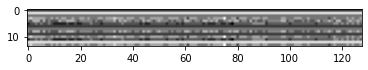

In [192]:
plt.imshow(stack_raw_signal_array_10,cmap="gray")

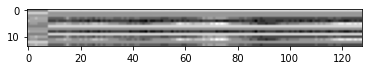

In [193]:
plt.imshow(stack_raw_signal_array_8,cmap="gray")

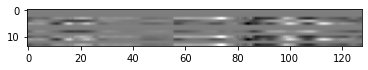

In [194]:
plt.imshow(stack_raw_signal_array_1,cmap="gray")

### DFT

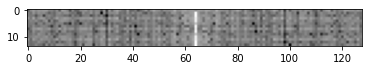

In [195]:
SI_fft_10 = np.fft.fft2(stack_raw_signal_array_10)
fshift_SI_10 = np.fft.fftshift(SI_fft_10)
magnitude_spectrum_SI_10 = np.log(np.abs(fshift_SI_10))
plt.imshow(magnitude_spectrum_SI_10,cmap="gray")
plt.show()

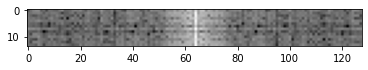

In [196]:
SI_fft_8 = np.fft.fft2(stack_raw_signal_array_8)
fshift_SI_8 = np.fft.fftshift(SI_fft_8)
magnitude_spectrum_SI_8 = np.log(np.abs(fshift_SI_8))
plt.imshow(magnitude_spectrum_SI_8,cmap="gray")
plt.show()

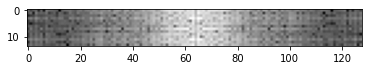

In [198]:
SI_fft_1 = np.fft.fft2(stack_raw_signal_array_1)
fshift_SI_1 = np.fft.fftshift(SI_fft_1)
magnitude_spectrum_SI_1 = np.log(np.abs(fshift_SI_1))
plt.imshow(magnitude_spectrum_SI_1,cmap="gray")
plt.show()